In [22]:
# %load ../init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import numpy as np
import holodeck as holo
import holodeck.single_sources as ss
import holodeck.cyutils as cy
import matplotlib.pyplot as plt
import kalepy as kale


import matplotlib.cm as cm
from holodeck import plot, utils
from holodeck.constants import YR, MSOL

# using single_source.py's ss_gws function with pspace

setup example

In [23]:
dur = 10.0*YR
cad = .2*YR



# 1) Choose the frequency bins at which to calculate the GWB, same as in semi-analytic-models.ipynb
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)

# 2) Build Semi-Analytic-Model with super simple parameters 
sam = holo.sam.Semi_Analytic_Model()
# get observed orbital frequency bin edges and centers 
# from observed GW frequency bin edges
fobs_orb_edges = fobs_edges / 2.0 # f_orb = f_GW/2
fobs_orb_cents = kale.utils.midpoints(fobs_edges) / 2.0

# 3) Get SAM edges and numbers as in sam.gwb()
# gets differential number of binaries per bin-vol per log freq interval
edges, dnum = sam.dynamic_binary_number(holo.hardening.Hard_GW, fobs_orb=fobs_orb_cents, zero_stalled=False)
edges[-1] = fobs_orb_edges
# integrate (multiply by bin volume) within each bin
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges))

sam = holo.sam.Semi_Analytic_Model()

22:47:27 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
22:47:27 INFO : Stalled SAM bins based on GMT: 1.98e+05/4.99e+05 = 3.96e-01 [sam.py:static_binary_density]
22:47:27 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
22:47:27 INFO : 	dens bef: (1.28e-114, 5.22e-53, 2.59e-13, 2.12e-03, 1.66e-02, 2.92e-02, 4.47e-02) [sam.py:static_binary_density]
22:47:33 INFO : Scatter added after 5.808856 sec [sam.py:static_binary_density]
22:47:33 INFO : 	dens aft: (6.14e-17, 7.92e-09, 2.90e-06, 2.19e-03, 1.69e-02, 2.92e-02, 4.27e-02) [sam.py:static_binary_density]
22:47:33 INFO : 	mass: 8.56e-02 ==> 8.54e-02 || change = -1.8507e-03 [sam.py:static_binary_density]
22:47:33 INFO : zeroing out 1.98e+05/4.99e+05 = 3.96e-01 systems stalled from GMT [sam.py:static_binary_density]
22:47:33 INFO : fraction of coalesced binaries: 4.33e+05/1.25e+07 = 3.47e-02 [sam.py:dynamic_binary_number]
22:47:33 WARNING : WARNING: _stalled_ binaries are not being ac

### Case A) just 1, no params

In [24]:
hc_ss, hc_bg= ss.ss_gws(edges, number, realize = 5, loudest=1, params=False)

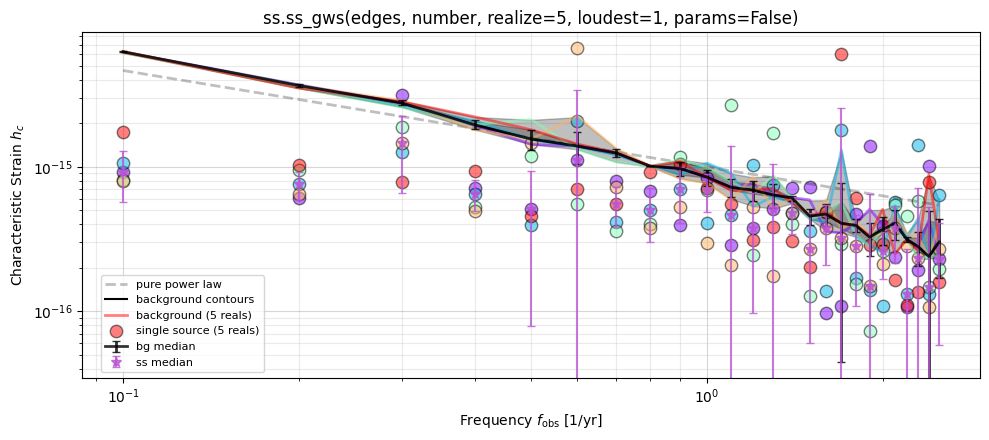

In [25]:
#optional:
INCLUDE_MEDIANS = True


fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title('ss.ss_gws(edges, number, realize=5, loudest=1, params=False)')
xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')


# plot the background contours 
ss.plot_BG(ax, xx, hc_bg, LABEL='background contours', COLOR='k',
           REALS=0, median = True)

# plot the first 5 realizations
ss.plot_samples(ax, xx, SS = hc_ss[...,0], BG = hc_bg, REALS=5, LABEL=' (5 reals)')


# plot medians and errorbars
ss.plot_medians(ax, xx, BG=hc_bg, SS=hc_ss[...,0], 
                BG_ERRORS=True, BG_COLOR='k',
                SS_ERRORS=True, SS_COLOR='mediumorchid')


legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), 
                       bbox_transform=fig.transFigure, loc='lower left',
                       fontsize=8)

# ax.set_ylim(1e-16, 3e-15)
fig.tight_layout()

### Case B) multiple loudest, no params

In [26]:
hc_ss, hc_bg = ss.ss_gws(edges, number, realize = 5, loudest = 3)

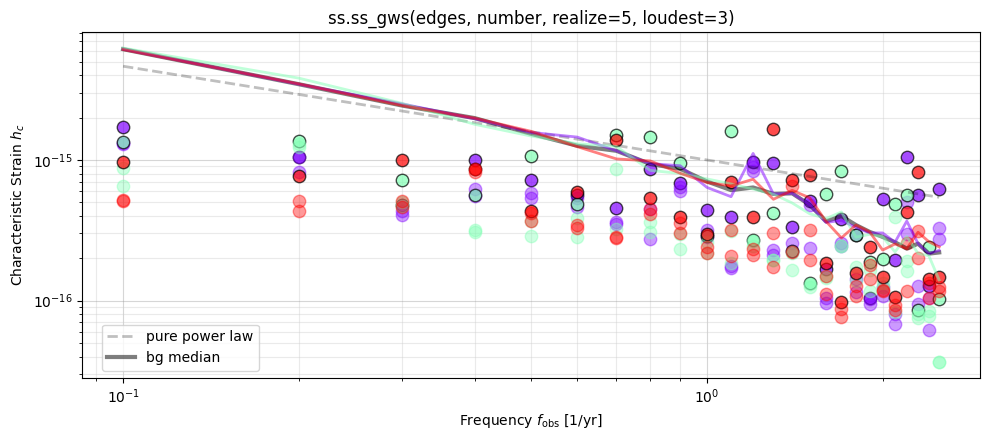

In [27]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title('ss.ss_gws(edges, number, realize=5, loudest=3)')

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the median background
ax.plot(xx, np.median(hc_bg, axis=1), label='bg median', color='k', lw=3, alpha=.5)

# plot all single sources in the first realization
REALS = 3
colors = cm.rainbow(np.linspace(0,1,REALS))
for rr in range(REALS):
    ax.plot(xx, hc_bg[:,rr], lw=2.0, alpha=0.5, color=colors[rr], linestyle='solid')
    for ll in range(len(hc_ss[0,0])):
        if(ll==0): 
            edgecolor = 'k'
            alpha = 0.7
        else: 
            edgecolor = None
            alpha = 0.4
        ax.scatter(xx,hc_ss[:,rr,ll], color=colors[rr], marker='o', s=80,
                    edgecolor=edgecolor, alpha=alpha)

# plot the model with Poisson sampling
# ss.plot_BG(ax, xx, hc_bg, LABEL='hc_bg, median of %d realizations'% hc_bg.shape[1], REALS=1, COLOR='b')


legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

### Case C) just 1, with params

In [28]:
hc_ss, hc_bg, sspar, bgpar = ss.ss_gws(edges, number, realize = 5, params=True)

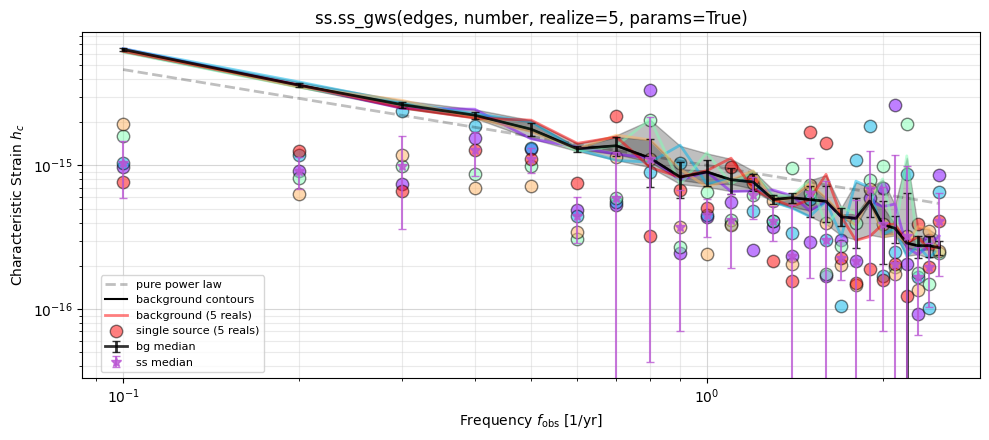

In [29]:
#optional:
INCLUDE_MEDIANS = True


fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title('ss.ss_gws(edges, number, realize=5, params=True)')
xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')


# plot the background contours 
ss.plot_BG(ax, xx, hc_bg, LABEL='background contours', COLOR='k',
           REALS=0, median = True)

# plot the first 5 realizations
ss.plot_samples(ax, xx, SS = hc_ss[...,0], BG = hc_bg, REALS=5, LABEL=' (5 reals)')


# plot medians and errorbars
ss.plot_medians(ax, xx, BG=hc_bg, SS=hc_ss[...,0], 
                BG_ERRORS=True, BG_COLOR='k',
                SS_ERRORS=True, SS_COLOR='mediumorchid')


legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), 
                       bbox_transform=fig.transFigure, loc='lower left',
                       fontsize=8)

# ax.set_ylim(1e-16, 3e-15)
fig.tight_layout()

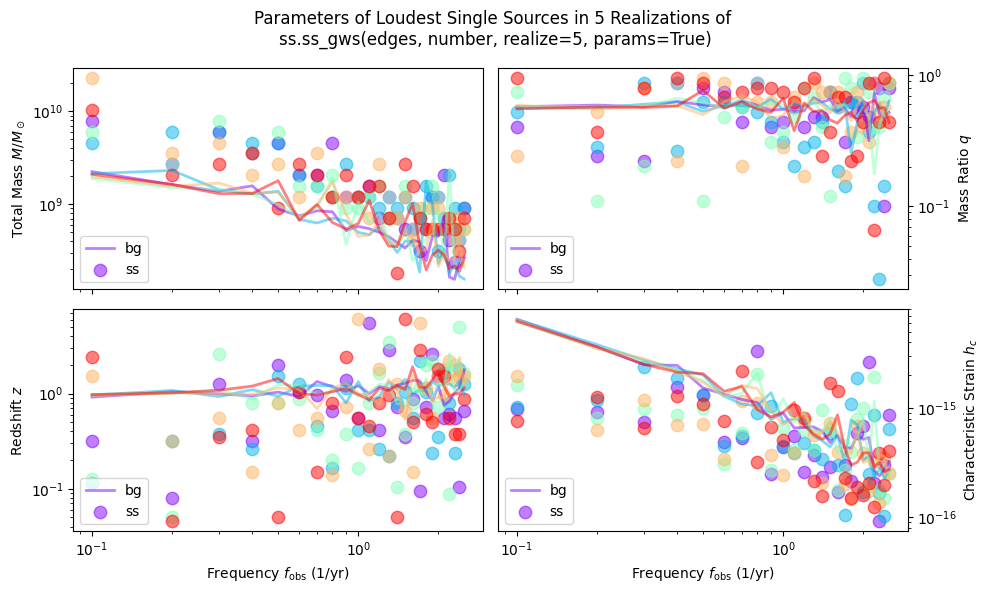

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10,6), sharex=True)
fig.suptitle(('Parameters of Loudest Single Sources in %d Realizations of ' % hc_bg.shape[1])
             +'\nss.ss_gws(edges, number, realize=5, params=True)')

grid = np.empty((2,2), dtype=list)
grid[0,0] = edges[0]/MSOL
grid[0,1] = edges[1]
grid[1,0] = edges[2]
grid[1,1] = edges[3]
xx = fobs * YR

bg_marr = bgpar[0,:,:]
bg_qarr = bgpar[1,:,:]
bg_zarr = bgpar[2,:,:]
bg_params = np.array([[bg_marr/MSOL, bg_qarr], [bg_zarr, hc_bg]])

ss_marr = sspar[0,:,:,0]
ss_qarr = sspar[1,:,:,0]
ss_zarr = sspar[2,:,:,0]
ss_params = np.array([[ss_marr/MSOL, ss_qarr], [ss_zarr, hc_ss[...,0]]])


ss.plot_params(axs, xx, grid, REALS=5, 
               BG_PARAMS=bg_params, SS_PARAMS=ss_params,
               BG_MEDIAN=False, SS_MEDIAN=False,
               SHOW_GRID=False)


fig.tight_layout()

### Case D) multiple, with params

In [31]:
hc_ss, hc_bg, sspar, bgpar = ss.ss_gws(edges, number, realize = 5, loudest = 3, params=True)

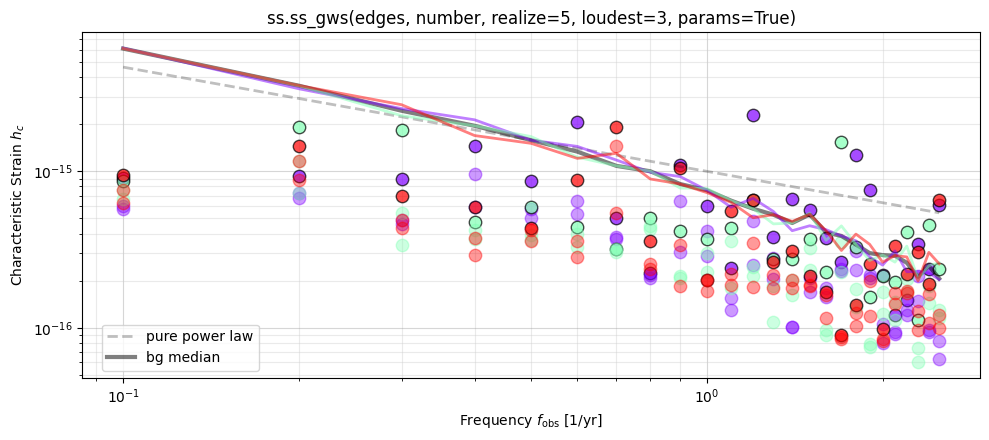

In [32]:
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title('ss.ss_gws(edges, number, realize=5, loudest=3, params=True)')

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the median background
ax.plot(xx, np.median(hc_bg, axis=1), label='bg median', color='k', lw=3, alpha=.5)

# plot all single sources in the first realization
REALS = 3
colors = cm.rainbow(np.linspace(0,1,REALS))
for rr in range(REALS):
    ax.plot(xx, hc_bg[:,rr], lw=2.0, alpha=0.5, color=colors[rr], linestyle='solid')
    for ll in range(len(hc_ss[0,0])):
        if(ll==0): 
            edgecolor = 'k'
            alpha = 0.7
        else: 
            edgecolor = None
            alpha = 0.4
        ax.scatter(xx,hc_ss[:,rr,ll], color=colors[rr], marker='o', s=80,
                    edgecolor=edgecolor, alpha=alpha)

# plot the model with Poisson sampling
# ss.plot_BG(ax, xx, hc_bg, LABEL='hc_bg, median of %d realizations'% hc_bg.shape[1], REALS=1, COLOR='b')


legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

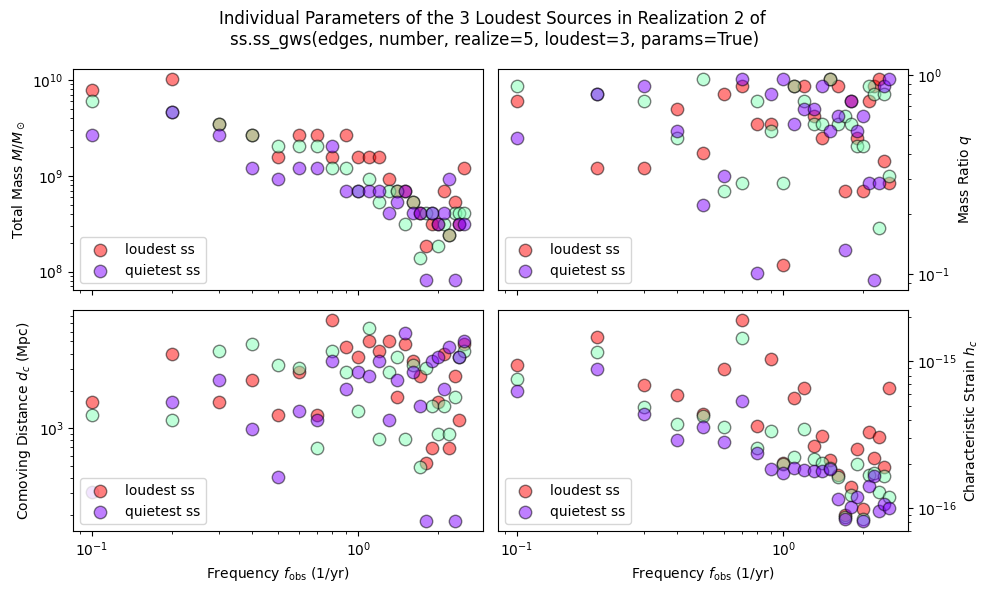

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(10,6), sharex=True)
rr = 2
L = len(hc_ss[0,0])
fig.suptitle(('Individual Parameters of the %d Loudest Sources in Realization %d of ' % (L,rr))
             +'\nss.ss_gws(edges, number, realize=5, loudest=3, params=True)')

grid = np.empty((2,2), dtype=list)
grid[0,0] = edges[0]/MSOL
grid[0,1] = edges[1]
grid[1,0] = edges[2]
grid[1,1] = edges[3]
xx = fobs * YR


ss_marr = sspar[0,...]
ss_qarr = sspar[1,...]
ss_zarr = sspar[2,...]
ss_darr = holo.cosmo.comoving_distance(ss_zarr).si.value * 3.241 * 10**-23 # Mpc


# shape(2, 2) each piece shape (F, R, L)
LL_PARAMS = np.array([[ss_marr/MSOL, ss_qarr], [ss_darr, hc_ss]])

# from single_sources.py
TITLES = np.array([['Total Mass $M/M_\odot$', 'Mass Ratio $q$'], 
                                   ['Comoving Distance $d_c$ (Mpc)', 'Characteristic Strain $h_c$']])
XLABEL = 'Frequency $f_\mathrm{obs}$ (1/yr)'
SHOW_GRID = False  
SHOW_LEGEND = True
LABEL=''           
colors = cm.rainbow(np.linspace(1,0,L))
for ii in range(len(axs)):
    for jj in range(len(axs)):
        axs[ii,jj].set_ylabel(TITLES[ii,jj])
        # if(ii==0 or jj==0): # mass, ratio, or redshift
        #     # bin edges
        #     for kk in range(len(grid[ii,jj])):
        #         if(kk==0): edgelabel='edges'
        #         else: edgelabel=None 
        #         if(SHOW_GRID == True):
        #             axs[ii,jj].axhline(grid[ii,jj][kk], color='k', alpha=0.6, lw=0.15, label=edgelabel)
                
        if (LL_PARAMS is not None):
            # single source realizations
            for ll in range(L):
                if(ll==0): 
                    sslabel = 'loudest ss'+LABEL
                elif(ll==L-1): 
                    sslabel = 'quietest ss'+LABEL
                else: 
                    sslabel = None
                axs[ii,jj].scatter(xx, LL_PARAMS[ii,jj,:,rr,ll], label=sslabel,
                                    color=colors[ll], marker='o', s=80, 
                                    alpha=0.5, edgecolor='k')
        axs[ii,jj].set_yscale('log')
        axs[ii,jj].set_xscale('log')
        if(ii==1): axs[ii,jj].set_xlabel(XLABEL)
        if(jj==1):
            axs[ii,jj].yaxis.set_label_position("right")
            axs[ii,jj].yaxis.tick_right()
        if(SHOW_LEGEND): axs[ii,jj].legend(loc='lower left')


fig.tight_layout()

# all from sam, for librarian.py function

In [34]:
dur = 10.0*YR
cad = .2*YR



# 1) Choose the frequency bins at which to calculate the GWB, same as in semi-analytic-models.ipynb
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)

# 2) Build Semi-Analytic-Model with super simple parameters 
sam = holo.sam.Semi_Analytic_Model()
# get observed orbital frequency bin edges and centers 
# from observed GW frequency bin edges
fobs_orb_edges = fobs_edges / 2.0 # f_orb = f_GW/2
fobs_orb_cents = kale.utils.midpoints(fobs_edges) / 2.0

# 3) Get SAM edges and numbers as in sam.gwb()
# gets differential number of binaries per bin-vol per log freq interval
edges, dnum = sam.dynamic_binary_number(holo.hardening.Hard_GW, fobs_orb=fobs_orb_cents, zero_stalled=False)
edges[-1] = fobs_orb_edges
# integrate (multiply by bin volume) within each bin
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges))

22:47:45 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
22:47:45 INFO : Stalled SAM bins based on GMT: 1.98e+05/4.99e+05 = 3.96e-01 [sam.py:static_binary_density]
22:47:46 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
22:47:46 INFO : 	dens bef: (1.28e-114, 5.22e-53, 2.59e-13, 2.12e-03, 1.66e-02, 2.92e-02, 4.47e-02) [sam.py:static_binary_density]
22:47:52 INFO : Scatter added after 5.862064 sec [sam.py:static_binary_density]
22:47:52 INFO : 	dens aft: (6.14e-17, 7.92e-09, 2.90e-06, 2.19e-03, 1.69e-02, 2.92e-02, 4.27e-02) [sam.py:static_binary_density]
22:47:52 INFO : 	mass: 8.56e-02 ==> 8.54e-02 || change = -1.8507e-03 [sam.py:static_binary_density]
22:47:52 INFO : zeroing out 1.98e+05/4.99e+05 = 3.96e-01 systems stalled from GMT [sam.py:static_binary_density]
22:47:52 INFO : fraction of coalesced binaries: 4.33e+05/1.25e+07 = 3.47e-02 [sam.py:dynamic_binary_number]
22:47:52 WARNING : WARNING: _stalled_ binaries are not being ac

In [35]:
print(sam.__dict__.keys())

dict_keys(['mtot', 'mrat', 'redz', '_gsmf', '_gpf', '_gmt', '_mmbulge', '_density', '_grid', '_shape', '_fisco', '_gmt_time', '_redz_prime', '_dynamic_binary_number', '_gwb', '_coal', '_stall'])
